<a href="https://colab.research.google.com/github/Rigboone-68/Data-Science-DEP/blob/main/Anomaly_Detection_in_Network_Traffic_Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)


Data Collection and Preprocessing

In [1]:

# Unzip the dataset
!unzip Cybersecurity.zip

Archive:  Cybersecurity.zip
  inflating: CloudWatch_Traffic_Web_Attack.csv  


In [9]:
# Loading the dataset
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')

# View the first few rows to understand the structure
print(df.head())

# Filling missing values (if any) - Only for numeric columns
for col in df.select_dtypes(include=np.number):
    df[col].fillna(df[col].mean(), inplace=True) # Fill missing values with the mean of each column

# Converting categorical variables to dummy variables (e.g., protocol types)
df = pd.get_dummies(df, columns=['protocol'], drop_first=True)


# Normalize the data - Select only numeric features for normalization
numeric_features = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Split the data into train and test sets
X = df[numeric_features]
target = 'response.code'
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0  10.138.69.97  Suspicious Web Traffic  

<ipython-input-9-e5ef5de40486>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True) # Fill missing values with the mean of each column


Isolation Forest Implementation

In [10]:
# Fitting Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies in the test set
y_pred_iso = iso_forest.predict(X_test)

# Convert -1 (anomalies) to 1 and 1 (normal) to 0 for easier evaluation
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# Evaluating the Isolation Forest model
print("Isolation Forest Classification Report:")
print(classification_report(y_pred_iso, np.zeros_like(y_pred_iso)))


Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        80
           1       0.00      0.00      0.00         5

    accuracy                           0.94        85
   macro avg       0.47      0.50      0.48        85
weighted avg       0.89      0.94      0.91        85



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Autoencoder Implementation

In [57]:
# Autoencoder for anomaly detection

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Defining the Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 14  # Number of neurons in the bottleneck layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training the autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1)

# Using the autoencoder to predict anomalies
reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# Setting a threshold for anomaly detection
threshold = np.percentile(mse, 95)
y_pred_auto = np.where(mse > threshold, 1, 0)

# Evaluating the Autoencoder model
print("Autoencoder Classification Report:")
print(classification_report(y_pred_auto, np.zeros_like(y_pred_auto)))


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.7003 - val_loss: 1.0864
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5534 - val_loss: 1.0678
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6466 - val_loss: 1.0492
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6812 - val_loss: 1.0326
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6180 - val_loss: 1.0174
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6038 - val_loss: 1.0035
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5693 - val_loss: 0.9909
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6064 - val_loss: 0.9794
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5806 - val_loss: 0.9692
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5499 - val_loss: 0.9597
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6969 - val_loss: 0.9500
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5315 - val_loss: 0.9416
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


One-Class SVM Implementation

In [12]:
# Fitting the One-Class SVM model
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)
svm.fit(X_train)

# Predicting anomalies in the test set
y_pred_svm = svm.predict(X_test)

# Convert -1 (anomalies) to 1 and 1 (normal) to 0 for easier evaluation
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Evaluating the One-Class SVM model
print("One-Class SVM Classification Report:")
print(classification_report(y_pred_svm, np.zeros_like(y_pred_svm)))


One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        83
           1       0.00      0.00      0.00         2

    accuracy                           0.98        85
   macro avg       0.49      0.50      0.49        85
weighted avg       0.95      0.98      0.96        85



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:

A confusion matrix can show how many instances of one class were correctly or incorrectly predicted.

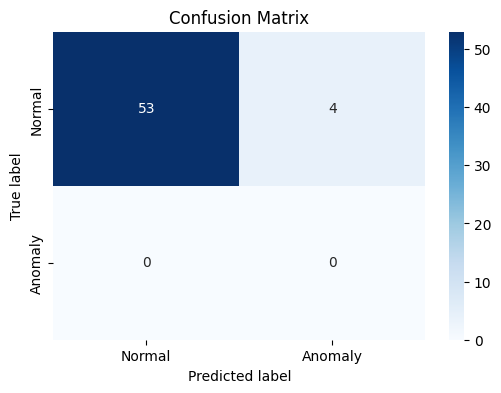

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_iso)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


Accuracy over Time

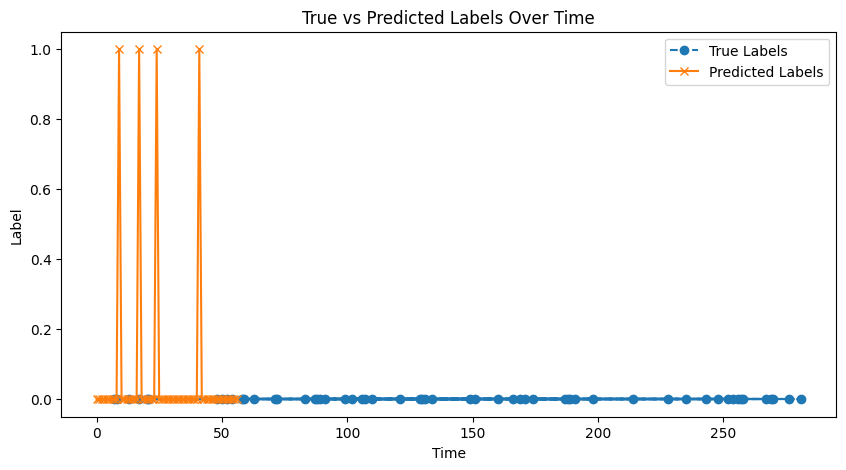

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label='True Labels', marker='o', linestyle='--')
plt.plot(y_pred_iso[:100], label='Predicted Labels', marker='x')
plt.xlabel('Time')
plt.ylabel('Label')
plt.title('True vs Predicted Labels Over Time')
plt.legend()
plt.show()


Precision-Recall Curve:

This is useful for evaluating model performance when dealing with imbalanced datasets.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


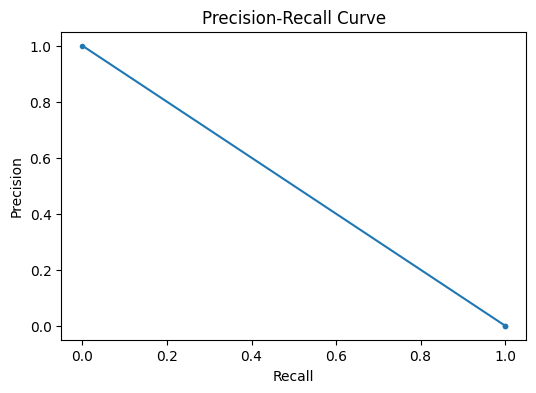

In [50]:
from sklearn.metrics import precision_recall_curve

# Computing Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_iso)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


 F1-Score Over Different Thresholds

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


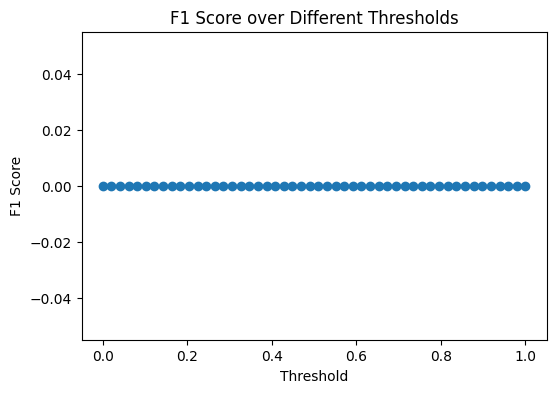

In [51]:
from sklearn.metrics import f1_score
import numpy as np


thresholds = np.linspace(0, 1, 50)
f1_scores = [f1_score(y_test, y_pred_iso > t) for t in thresholds]

plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score over Different Thresholds')
plt.show()


Distribution of Anomalies Detected

<ipython-input-52-a43062456f65>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_iso, palette="Set2")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


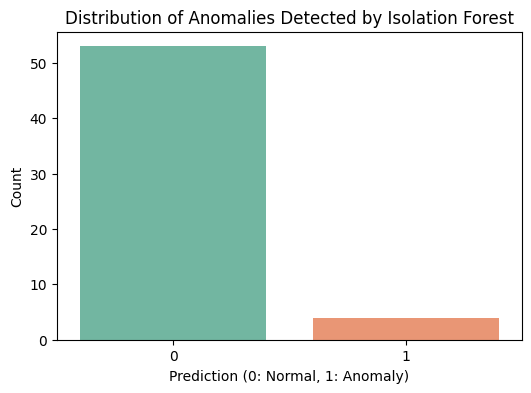

In [52]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_pred_iso, palette="Set2")
plt.title("Distribution of Anomalies Detected by Isolation Forest")
plt.xlabel("Prediction (0: Normal, 1: Anomaly)")
plt.ylabel("Count")
plt.show()


Error Analysis: False Positives and False Negatives

Analyzing where the model makes mistakes can be very informative. You can inspect false positives (normal instances incorrectly classified as anomalies) and false negatives (anomalies classified as normal).

In [56]:
# False positives and false negatives
false_positives = np.where((y_pred_iso == 1) & (y_test == 0))[0]
false_negatives = np.where((y_pred_iso == 0) & (y_test == 1))[0]

print(f"Number of False Positives: {len(false_positives)}")
print(f"Number of False Negatives: {len(false_negatives)}")


Number of False Positives: 4
Number of False Negatives: 0
